<a href="https://colab.research.google.com/github/isshii/de4test/blob/test_koyama/DeepXplore_kaggle_model_20200116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 共通で使うパスなどの定義
# 共通の変数設定
# 共通フォルダパス
data_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data"
data_imagenet_generated = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/generated_inputs/"
data_imagenet = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet"
data_imagenet_seeds = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
model_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/model"
output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output"
tmp_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/tmp"

In [3]:
# Goggle Drive つなぐ
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# outputフォルダ内容物のクリーンアップ削除
#!rm "$output_dir"/*

In [5]:
import argparse

%tensorflow_version 1.x
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Input
import imageio

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


Using TensorFlow backend.


In [37]:
#@title デフォルトのタイトル テキスト
# DeepXplore のパラメータ設定部
# read the parameter
# argument parsing
parser = argparse.ArgumentParser(description='Main function for difference-inducing input generation in MNIST dataset')
parser.add_argument('transformation', help="realistic transformation type", choices=['light', 'occl', 'blackout'])
parser.add_argument('weight_diff', help="weight hyperparm to control differential behavior", type=float)
parser.add_argument('weight_nc', help="weight hyperparm to control neuron coverage", type=float)
parser.add_argument('step', help="step size of gradient descent", type=float)
parser.add_argument('seeds', help="number of seeds of input", type=int)
parser.add_argument('grad_iterations', help="number of iterations of gradient descent", type=int)
parser.add_argument('threshold', help="threshold for determining neuron activated", type=float)
parser.add_argument('-t', '--target_model', help="target model that we want it predicts differently",
                    choices=[0, 1, 2], default=0, type=int)
sp_x = 0
sp_y = 0
occl_x = 255
occl_y = 255
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(sp_x, sp_y), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(occl_x, occl_y), type=tuple)



_StoreAction(option_strings=['-occl_size', '--occlusion_size'], dest='occlusion_size', nargs=None, const=None, default=(255, 255), type=<class 'tuple'>, choices=None, help='occlusion size', metavar=None)

In [0]:
#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "occl" #@param ["light", "occl", "blackout"]
weight_diff = "3.0" #@param {type:"string"}
weight_nc = "3.0" #@param {type:"string"}
step = "1" #@param {type:"string"}
seeds = "10" #@param {type:"string"}
grad_iterations = "100" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}
#-t = "0" #@param ["0", "1", "2"]




In [0]:
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [0]:
import random
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing import image
import os, re

import random, string

def randomname(n):
   randlst = [random.choice(string.ascii_letters + string.digits) for i in range(n)]
   return ''.join(randlst)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    input_img_data = image.img_to_array(img)
    input_img_data = np.expand_dims(input_img_data, axis=0)
    input_img_data = preprocess_input(input_img_data)  # final input shape = (1,224,224,3)
    return input_img_data

def preprocess_image2(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    input_img_data = image.img_to_array(img)
    input_img_data = np.expand_dims(input_img_data, axis=0)
    input_img_data = preprocess_input(input_img_data)  # final input shape = (1,224,224,3)
    return input_img_data


def deprocess_image(x):
    x = x.reshape((224, 224, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def decode_label(pred):
    return decode_predictions(pred)[0][0][1]


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def constraint_occl(gradients, start_point, rect_shape):
    new_grads = np.zeros_like(gradients)
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
    return new_grads


def constraint_light(gradients):
    new_grads = np.ones_like(gradients)
    grad_mean = 1e4 * np.mean(gradients)
    return grad_mean * new_grads


def constraint_black(gradients, rect_shape=(10, 10)):
    start_point = (
        random.randint(0, gradients.shape[1] - rect_shape[0]), random.randint(0, gradients.shape[2] - rect_shape[1]))
    new_grads = np.zeros_like(gradients)
    patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
    if np.mean(patch) < 0:
        new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
        start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
    return new_grads


def init_coverage_tables(model1, model2, model3):
    model_layer_dict1 = defaultdict(bool)
    model_layer_dict2 = defaultdict(bool)
    model_layer_dict3 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    init_dict(model2, model_layer_dict2)
    init_dict(model3, model_layer_dict3)
    return model_layer_dict1, model_layer_dict2, model_layer_dict3


def init_dict(model, model_layer_dict):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_dict[(layer.name, index)] = False


def neuron_to_cover(model_layer_dict):
    not_covered = [(layer_name, index) for (layer_name, index), v in list(model_layer_dict.items()) if not v]
    if not_covered:
        layer_name, index = random.choice(not_covered)
    else:
        layer_name, index = random.choice(list(model_layer_dict.keys()))
    return layer_name, index


def neuron_covered(model_layer_dict):
    covered_neurons = len([v for v in list(model_layer_dict.values()) if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)


def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled


def update_coverage(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            if np.mean(scaled[..., num_neuron]) > threshold and not model_layer_dict[(layer_names[i], num_neuron)]:
                model_layer_dict[(layer_names[i], num_neuron)] = True
    print("update coverage finished")


def full_coverage(model_layer_dict):
    if False in list(model_layer_dict.values()):
        return False
    return True


def fired(model, layer_name, index, input_data, threshold=0):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_output = intermediate_layer_model.predict(input_data)[0]
    scaled = scale(intermediate_layer_output)
    if np.mean(scaled[..., index]) > threshold:
        return True
    return False


def diverged(predictions1, predictions2, predictions3, target):
    if not predictions1 == predictions2 == predictions3:
        return True
    return False

#add
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

In [0]:
########以下、変更

In [0]:
from keras import models
from keras import optimizers
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

In [14]:
# モデル構築
# 参照元 : https://www.kaggle.com/rohit1277/cat-dog-classifier-using-vgg16-transfer-learning
# model名 : good_vgg16.h5
# Dropbox保存先 : https://www.dropbox.com/home/TOPSE/model
# Gdrive保存先 : /content/gdrive/My Drive/ColabNotebooks/test4ai/model

img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 3)
input_tensor = Input(shape=input_shape)

model1 = VGG16(weights='imagenet',input_tensor=input_tensor,include_top=True)

for layers in (model1.layers)[:19]:
    print(layers)
    layers.trainable = False
X= model1.layers[-2].output
predictions1 = Dense(2, activation="softmax",name='model1_output')(X) #出力層のnameを追加
model1 = Model(input = model1.input, output = predictions1)
model1.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

vgg16_weights = model_dir + '/good_vgg16.h5'
model1.load_weights(vgg16_weights)

model1.summary()





553467904/553467096 [==============================] - 7s 0us/step










/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`
  del sys.path[0]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [15]:
#resnet50の層が詳細化されているものに変更
#Kerasには詳細化されたモデルのh5ファイルがなかったので、githubのh5ファイルを使用
# model2 = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape)
model2 = ResNet50(weights='imagenet',input_tensor=input_tensor, include_top=True)

#classes = list(iter(batches.class_indices))
model2.layers.pop()
for layer in model2.layers:
    layer.trainable=False
last = model2.layers[-1].output
x = Dense(2, activation="softmax",name='model2_output')(last)
model2 = Model(model2.input, x)
model2.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#finetuned_model.summary()

#resnet_weights = model_dir + '/resnet50_best.h5'
resnet_weights = model_dir + '/resnet50_best.h5'
model2.load_weights(resnet_weights)

model2.summary()




102858752/102853048 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________

In [16]:
# model3 = ResNet50(weights='imagenet', include_top=True, input_shape=input_shape)
model3 = ResNet50(weights='imagenet',input_tensor=input_tensor, include_top=True)

#classes = list(iter(batches.class_indices))
model3.layers.pop()
for layer in model3.layers:
    layer.trainable=False
last = model3.layers[-1].output
x = Dense(2, activation="softmax",name='model3_output')(last)
model3 = Model(model3.input, x)
model3.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
#finetuned_model.summary()

resnet_weights = model_dir + '/resnet50_best.h5'
model3.load_weights(resnet_weights)


model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
#摂動を加える犬猫画像のパスに変えたいです。
img_paths = list_pictures("/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats")

K.set_learning_phase(0)
model_layer_dict1, model_layer_dict2, model_layer_dict3 = init_coverage_tables(model1, model2, model3)

In [18]:
!ls data_imagenet_seeds+"/"


ls: cannot access 'data_imagenet_seeds+/': No such file or directory


In [19]:
img_paths

['/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog3.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog5.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog4.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog1.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat3.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog2.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat4.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat5.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat1.jpg']

In [20]:
print(data_imagenet_seeds+"/dog&cats/")

/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dog&cats/


In [26]:
gen_img

array([[[[ 98.442276 , 107.60228  ,  98.70128  ],
         [ 97.442276 , 106.60228  ,  97.70128  ],
         [102.442276 , 110.60228  , 104.70128  ],
         ...,
         [ 91.442276 ,  92.60228  , 104.70128  ],
         [ 91.442276 ,  92.60228  , 104.70128  ],
         [ 91.442276 ,  92.60228  , 104.70128  ]],

        [[ 98.442276 , 107.60228  ,  98.70128  ],
         [ 97.442276 , 106.60228  ,  97.70128  ],
         [102.442276 , 110.60228  , 104.70128  ],
         ...,
         [ 91.442276 ,  92.60228  , 104.70128  ],
         [ 91.442276 ,  92.60228  , 104.70128  ],
         [ 91.442276 ,  92.60228  , 104.70128  ]],

        [[ 98.442276 , 107.60228  ,  98.70128  ],
         [ 97.442276 , 106.60228  ,  97.70128  ],
         [102.442276 , 110.60228  , 104.70128  ],
         ...,
         [ 92.442276 ,  93.60228  , 105.70128  ],
         [ 92.442276 ,  93.60228  , 105.70128  ],
         [ 92.442276 ,  93.60228  , 105.70128  ]],

        ...,

        [[ 16.442278 , -44.397728 , -8

In [27]:
img_paths

['/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog3.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog5.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog4.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog1.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat3.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog2.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat4.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat5.jpg',
 '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat1.jpg']

In [28]:
args.seeds

10

In [25]:
%%time

for _ in range(args.seeds):
    #gen_img = preprocess_image(random.choice(img_paths))
    
    gen_img = preprocess_image(random.choice(img_paths))
    #gen_img2 = preprocess_image2(random.choice(img_paths))
    orig_img = gen_img.copy()
    # first check if input already induces differences
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
    if not label1 == label2 == label3:
      ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理 Start ########################
      print('input already causes different outputs: {}, {}, {}'.format(label1, label2 ,label3) + bcolors.ENDC) 

      update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
      print("updatting coverage for model1")
      update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
      print("updatting coverage for model3")
      update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
      print("updatting coverage for model2")

      print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
      #        print('covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
            % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
      #                 neuron_covered(model_layer_dict3)[2]))

      averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                      neuron_covered(model_layer_dict3)[0]) / float(
          neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
          neuron_covered(model_layer_dict3)[
              1])
      print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
      print('averaged covered neurons %.3f' % averaged_nc)

      gen_img_deprocessed = deprocess_image(gen_img)

      # save the result to disk
      #imsave('./generated_inputs/' + 'already_differ_' + decode_label(pred1) + '_' + decode_label(
      imageio.imwrite(data_imagenet_generated + 'already_differ_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png',
              gen_img_deprocessed)
      continue
      ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理END ########################

    ######################## 予測が3つのモデルで同じ場合の処理 Start ########################
    # if all label agrees
    orig_label = label1
    layer_name1, index1 = neuron_to_cover(model_layer_dict1)
    layer_name2, index2 = neuron_to_cover(model_layer_dict2)
    layer_name3, index3 = neuron_to_cover(model_layer_dict3)
    # construct joint loss function
    if args.target_model == 0:
        #weight_diff param
        loss1 = -args.weight_diff * K.mean(model1.get_layer('model1_output').output[..., orig_label])
        loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
    elif args.target_model == 1:
        loss1 = K.mean(model1.get_layer('model1_output').output[..., orig_label])
        loss2 = -args.weight_diff * K.mean(model2.get_layer('model2_output').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
    elif args.target_model == 2:
        loss1 = K.mean(model1.get_layer('model1_output').output[..., label1])
        loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
        loss3 = -args.weight_diff * K.mean(model3.get_layer('model3_output').output[..., orig_label])
    loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
    loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
    loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
    layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)    

    # for adversarial image generation
    final_loss = K.mean(layer_output)

    # we compute the gradient of the input picture wrt this loss
    grads = normalize(K.gradients(final_loss, input_tensor)[0])

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])
#    print("=============")
#    print(input_tensor)
#    print(loss1)
#    print(loss2)
#    print(loss3)
#    print(loss1_neuron)
#    print(loss2_neuron)
#    print(loss3_neuron)
#    print("=============")
#    print(gen_img.shape)
 
    # we run gradient ascent for 20 steps
    for iters in range(args.grad_iterations):
        
        ###########################error
        #iterate([gen_img])でエラーです
#        print("error ")
        loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate([gen_img])
#        print("error ??")
        if args.transformation == 'light':
            grads_value = constraint_light(grads_value)  # constraint the gradients value
        elif args.transformation == 'occl':
            grads_value = constraint_occl(grads_value, args.start_point,
                                          args.occlusion_size)  # constraint the gradients value
        elif args.transformation == 'blackout':
            grads_value = constraint_black(grads_value)  # constraint the gradients value

        gen_img += grads_value * args.step
        pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
        label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

        if not label1 == label2 == label3:
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

            print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
                  % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                      neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                      neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                            neuron_covered(model_layer_dict3)[0]) / float(
                neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[
                    1])
            print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
            print('averaged covered neurons %.3f' % averaged_nc)

            gen_img_deprocessed = deprocess_image(gen_img)
            orig_img_deprocessed = deprocess_image(orig_img)

            # save the result to disk
            #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
            #0 dog,1 cat

            name_chande = lambda label1: "dog" if label1 == 0 else 'cat'
            label1 = name_chande(label1)
            label2 = name_chande(label2)
            label3 = name_chande(label3)

            if args.transformation == 'light':
              rd = randomname(6)
              grads_value = constraint_light(grads_value)  # constraint the gradients value
              imageio.imwrite(data_imagenet_generated + args.transformation + '_' + weight_diff + '_' + weight_nc + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
              #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
              imageio.imwrite(data_imagenet_generated + args.transformation + '_' + weight_diff + '_' + weight_nc + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
            elif args.transformation == 'occl':
              rd = randomname(6)
              grads_value = constraint_occl(grads_value, args.start_point,args.occlusion_size)  # constraint the gradients value
              imageio.imwrite(data_imagenet_generated + args.transformation + '_' + weight_diff + '_' + weight_nc + '_' + sp_x + '_' + sp_y + '_' + occl_x + '_' + occl_y + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
              #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
              imageio.imwrite(data_imagenet_generated + args.transformation + '_' + weight_diff + '_' + weight_nc + '_' + sp_x + '_' + sp_y + '_' + occl_x + '_' + occl_y + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
            elif args.transformation == 'blackout':
              rd = randomname(6)
              grads_value = constraint_black(grads_value)  # constraint the gradients value
              imageio.imwrite(data_imagenet_generated + args.transformation + '_' + weight_diff + '_' + weight_nc + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
              #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
              imageio.imwrite(data_imagenet_generated + args.transformation + '_' + weight_diff + '_' + weight_nc + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
            break

CPU times: user 3min 48s, sys: 17.1 s, total: 4min 5s
Wall time: 3min 54s


In [95]:
#gen_img = preprocess_image(random.choice(img_paths))
img_paths = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg'
gen_img = preprocess_image(img_paths)
#gen_img2 = preprocess_image2(random.choice(img_paths))
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
if not label1 == label2 == label3:
  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理 Start ########################
  print('input already causes different outputs: {}, {}, {}'.format(label1, label2 ,label3) + bcolors.ENDC) 

  update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
  print("updatting coverage for model1")
  update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
  print("updatting coverage for model3")
  update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
  print("updatting coverage for model2")

  print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
  #        print('covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
        % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
            neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
            neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
  #                 neuron_covered(model_layer_dict3)[2]))

  averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                  neuron_covered(model_layer_dict3)[0]) / float(
      neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
      neuron_covered(model_layer_dict3)[
          1])
  print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
  print('averaged covered neurons %.3f' % averaged_nc)

  gen_img_deprocessed = deprocess_image(gen_img)

  # save the result to disk
  #imsave('./generated_inputs/' + 'already_differ_' + decode_label(pred1) + '_' + decode_label(
  imageio.imwrite(data_imagenet_generated + 'already_differ_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png',
          gen_img_deprocessed)

  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理END ########################

######################## 予測が3つのモデルで同じ場合の処理 Start ########################
# if all label agrees
orig_label = label1
layer_name1, index1 = neuron_to_cover(model_layer_dict1)
layer_name2, index2 = neuron_to_cover(model_layer_dict2)
layer_name3, index3 = neuron_to_cover(model_layer_dict3)
# construct joint loss function
if args.target_model == 0:
    #weight_diff param
    loss1 = -args.weight_diff * K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 1:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = -args.weight_diff * K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 2:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., label1])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = -args.weight_diff * K.mean(model3.get_layer('model3_output').output[..., orig_label])
loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)    

# for adversarial image generation
final_loss = K.mean(layer_output)

# we compute the gradient of the input picture wrt this loss
grads = normalize(K.gradients(final_loss, input_tensor)[0])

# this function returns the loss and grads given the input picture
iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])
#    print("=============")
#    print(input_tensor)
#    print(loss1)
#    print(loss2)
#    print(loss3)
#    print(loss1_neuron)
#    print(loss2_neuron)
#    print(loss3_neuron)
#    print("=============")
#    print(gen_img.shape)

# we run gradient ascent for 20 steps
for iters in range(args.grad_iterations):
    
    ###########################error
    #iterate([gen_img])でエラーです
#        print("error ")
    loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate([gen_img])
#        print("error ??")
    if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value
    elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)  # constraint the gradients value
    elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

    gen_img += grads_value * args.step
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

    if not label1 == label2 == label3:
        update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
        update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
        update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

        print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
              % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                  neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                        neuron_covered(model_layer_dict3)[0]) / float(
            neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
            neuron_covered(model_layer_dict3)[
                1])
        print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
        print('averaged covered neurons %.3f' % averaged_nc)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
        #0 dog,1 cat

        name_chande = lambda label1: "dog" if label1 == 1 else 'cat'
        label1 = name_chande(label1)
        label2 = name_chande(label2)
        label3 = name_chande(label3)

        if args.transformation == 'light':
          rd = randomname(6)
          grads_value = constraint_light(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'occl':
          rd = randomname(6)
          grads_value = constraint_occl(grads_value, args.start_point,args.occlusion_size)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'blackout':
          rd = randomname(6)
          grads_value = constraint_black(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        break

update coverage finished
update coverage finished
update coverage finished
covered neurons percentage 13890 neurons 0.434, 93125 neurons 0.796, 93125 neurons 0.796
averaged covered neurons 0.771
averaged covered neurons 0.771


In [0]:
#gen_img = preprocess_image(random.choice(img_paths))
img_paths = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/dog1.jpg'
gen_img = preprocess_image(img_paths)
#gen_img2 = preprocess_image2(random.choice(img_paths))
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

In [91]:
pred1, pred2, pred3

(array([[0.32779452, 0.67220545]], dtype=float32),
 array([[0.30508348, 0.6949165 ]], dtype=float32),
 array([[0.30508348, 0.6949165 ]], dtype=float32))

In [92]:
label1, label2, label3

(1, 1, 1)

In [96]:
#パッケージインストール
!pip install --upgrade azure-cognitiveservices-vision-computervision

     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 51kB 10.1MB/s 


In [0]:
#モジュールインポート
import os
import sys
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import pprint
import urllib.error
import urllib.request

from PIL import Image
from io import BytesIO
from datetime import datetime as dt
from datetime import datetime
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import TextOperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import TextRecognitionMode
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

%matplotlib inline

In [0]:
#環境変数に認証情報を設定
os.environ['COMPUTER_VISION_ENDPOINT'] = 'https://ai-test-customvision.cognitiveservices.azure.com/'
os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY'] = 'eeb28cce620f4b1ead515ec6d1d70c4f'

In [0]:
# Add your Computer Vision subscription key and endpoint to your environment variables.
if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
    subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
else:
    print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
    sys.exit()

if 'COMPUTER_VISION_ENDPOINT' in os.environ:
    endpoint = os.environ['COMPUTER_VISION_ENDPOINT']

In [0]:
#APIエンドポイント,認証情報設定
computervision_client = ComputerVisionClient(os.environ['COMPUTER_VISION_ENDPOINT'], CognitiveServicesCredentials(os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']))

In [0]:
def image_analysis_local(path):
    #ローカル画像の解析
    #print("===== Tag an image - local =====")
    # Open local image file
    local_image = open(local_image_path, "rb")
    # Call API local image
    tags_result_local = computervision_client.tag_image_in_stream(local_image)

    # Print results with confidence score
    #print("Tags in the local image: ")
    global res
    res = ""
    if (len(tags_result_local.tags) == 0):
        print("No tags detected.")
    else:
        for tag in tags_result_local.tags:
            #print("'{}' with confidence {:.2f}%".format(tag.name, tag.confidence * 100))
            res = res + "'{}' with confidence {:.2f}%".format(tag.name, tag.confidence * 100) + "\n"     
    #print()
    '''
    END - Tag an image - local
    '''
    return res

NewConnectionError: ignored

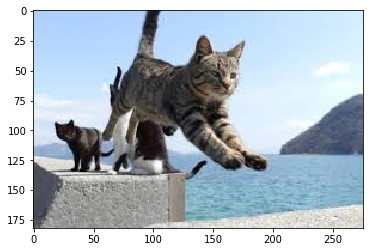

In [102]:
#画像のパス
local_image_path = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg'
#画像読み込み(日本語文字列不可)
src = cv2.imread('/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg')
#入力画像出力
plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
print(image_analysis_local(local_image_path))

In [0]:
#gen_img = preprocess_image(random.choice(img_paths))
img_paths = out_path
gen_img = preprocess_image(img_paths)
#gen_img2 = preprocess_image2(random.choice(img_paths))
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

In [111]:
pred1, pred2, pred3

(array([[0.28038093, 0.71961904]], dtype=float32),
 array([[0.99835443, 0.00164558]], dtype=float32),
 array([[0.99835443, 0.00164558]], dtype=float32))

In [106]:
data_imagenet_generated 

'/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/generated_inputs/'

In [0]:
out_path = data_imagenet_generated + "occl_3.0_3.0_0_0_255_255_dog_cat_cat_GFrbLX.png"

In [109]:
out_path

'/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/generated_inputs/occl_3.0_3.0_0_0_255_255_dog_cat_cat_GFrbLX.png'

In [0]:
sp_x = 0
sp_y = 0
occl_x = 255
occl_y = 255
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(sp_x, sp_y), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(occl_x, occl_y), type=tuple)
#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "occl" #@param ["light", "occl", "blackout"]
weight_diff = "3.0" #@param {type:"string"}
weight_nc = "3.0" #@param {type:"string"}
step = "1" #@param {type:"string"}
seeds = "10" #@param {type:"string"}
grad_iterations = "100" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}
#-t = "0" #@param ["0", "1", "2"]
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [112]:
sp_x = 0
sp_y = 0
occl_x = 125
occl_y = 125
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(sp_x, sp_y), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(occl_x, occl_y), type=tuple)
noise_type = "occl"
weight_diff = "3.0"
weight_nc = "3.0"
step = "1"
seeds = "10"
grad_iterations = "100"
threshold = "0.1"
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

ArgumentError: ignored

In [0]:
#gen_img = preprocess_image(random.choice(img_paths))
img_paths = '/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds/dogcats/cat2.jpg'
gen_img = preprocess_image(img_paths)
#gen_img2 = preprocess_image2(random.choice(img_paths))
orig_img = gen_img.copy()
# first check if input already induces differences
pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])
if not label1 == label2 == label3:
  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理 Start ########################
  print('input already causes different outputs: {}, {}, {}'.format(label1, label2 ,label3) + bcolors.ENDC) 

  update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
  print("updatting coverage for model1")
  update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
  print("updatting coverage for model3")
  update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
  print("updatting coverage for model2")

  print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
  #        print('covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
        % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
            neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
            neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
  #                 neuron_covered(model_layer_dict3)[2]))

  averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                  neuron_covered(model_layer_dict3)[0]) / float(
      neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
      neuron_covered(model_layer_dict3)[
          1])
  print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
  print('averaged covered neurons %.3f' % averaged_nc)

  gen_img_deprocessed = deprocess_image(gen_img)

  # save the result to disk
  #imsave('./generated_inputs/' + 'already_differ_' + decode_label(pred1) + '_' + decode_label(
  imageio.imwrite(data_imagenet_generated + 'already_differ_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png',
          gen_img_deprocessed)

  ######################## 摂動を加えなくても予測が3つのモデルで異なる場合の処理END ########################

######################## 予測が3つのモデルで同じ場合の処理 Start ########################
# if all label agrees
orig_label = label1
layer_name1, index1 = neuron_to_cover(model_layer_dict1)
layer_name2, index2 = neuron_to_cover(model_layer_dict2)
layer_name3, index3 = neuron_to_cover(model_layer_dict3)
# construct joint loss function
if args.target_model == 0:
    #weight_diff param
    loss1 = -args.weight_diff * K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 1:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., orig_label])
    loss2 = -args.weight_diff * K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = K.mean(model3.get_layer('model3_output').output[..., orig_label])
elif args.target_model == 2:
    loss1 = K.mean(model1.get_layer('model1_output').output[..., label1])
    loss2 = K.mean(model2.get_layer('model2_output').output[..., orig_label])
    loss3 = -args.weight_diff * K.mean(model3.get_layer('model3_output').output[..., orig_label])
loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)    

# for adversarial image generation
final_loss = K.mean(layer_output)

# we compute the gradient of the input picture wrt this loss
grads = normalize(K.gradients(final_loss, input_tensor)[0])

# this function returns the loss and grads given the input picture
iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])
#    print("=============")
#    print(input_tensor)
#    print(loss1)
#    print(loss2)
#    print(loss3)
#    print(loss1_neuron)
#    print(loss2_neuron)
#    print(loss3_neuron)
#    print("=============")
#    print(gen_img.shape)

# we run gradient ascent for 20 steps
for iters in range(args.grad_iterations):
    
    ###########################error
    #iterate([gen_img])でエラーです
#        print("error ")
    loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate([gen_img])
#        print("error ??")
    if args.transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value
    elif args.transformation == 'occl':
        grads_value = constraint_occl(grads_value, args.start_point,
                                      args.occlusion_size)  # constraint the gradients value
    elif args.transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

    gen_img += grads_value * args.step
    pred1, pred2, pred3 = model1.predict(gen_img), model2.predict(gen_img), model3.predict(gen_img)
    label1, label2, label3 = np.argmax(pred1[0]), np.argmax(pred2[0]), np.argmax(pred3[0])

    if not label1 == label2 == label3:
        update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
        update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
        update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

        print(bcolors.OKGREEN + 'covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'
              % (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                  neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
        averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                        neuron_covered(model_layer_dict3)[0]) / float(
            neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
            neuron_covered(model_layer_dict3)[
                1])
        print(bcolors.OKGREEN + 'averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)
        print('averaged covered neurons %.3f' % averaged_nc)

        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)

        # save the result to disk
        #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
        #0 dog,1 cat

        name_chande = lambda label1: "dog" if label1 == 1 else 'cat'
        label1 = name_chande(label1)
        label2 = name_chande(label2)
        label3 = name_chande(label3)

        if args.transformation == 'light':
          rd = randomname(6)
          grads_value = constraint_light(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'occl':
          rd = randomname(6)
          grads_value = constraint_occl(grads_value, args.start_point,args.occlusion_size)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(sp_x) + '_' + str(sp_y) + '_' + str(occl_x) + '_' + str(occl_y) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        elif args.transformation == 'blackout':
          rd = randomname(6)
          grads_value = constraint_black(grads_value)  # constraint the gradients value
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '.png', gen_img_deprocessed)
          #imsave('./generated_inputs/' + args.transformation + '_' + decode_label(pred1) + '_' + decode_label(
          imageio.imwrite(data_imagenet_generated + args.transformation + '_' + str(weight_diff) + '_' + str(weight_nc) + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_' + str(rd) + '_orig.png', orig_img_deprocessed)
        break